In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
tf.enable_eager_execution()
import importlib
import os

from matplotlib import pyplot as plt
%matplotlib notebook

from transliteration import data, train, model_one, script, decode, evaluate

In [2]:
importlib.reload(data)
batch_size = 128
muse_train_dataset = data.make_dataset('../data/tfrecord/muse_train.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
muse_valid_dataset = data.make_dataset('../data/tfrecord/muse_valid.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
muse_test_dataset = data.make_dataset('../data/tfrecord/muse_test.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)
eob_train_dataset = data.make_dataset('../data/tfrecord/eob_train.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
eob_valid_dataset = data.make_dataset('../data/tfrecord/eob_valid.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
eob_test_dataset = data.make_dataset('../data/tfrecord/eob_test.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)

In [3]:
importlib.reload(model_one)
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred)
    return tf.reduce_mean(loss_ * mask)


ja_encoder_config = model_one.Config(lstm_size=120,
                                      embedding_size=30,
                                      attention_size=None,
                                      vocab_size=script.SCRIPTS['en'].vocab_size)
ja_decoder_config = model_one.Config(lstm_size=120,
                                     embedding_size=30,
                                     attention_size=60,
                                     attention='monotonic_bahdanau',
                                     vocab_size=script.SCRIPTS['ja'].vocab_size)
ja_encoder = model_one.Encoder(ja_encoder_config)
ja_decoder = model_one.Decoder(ja_decoder_config)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
def make_checkpoint_obj():
    return tf.train.Checkpoint(optimizer=optimizer,
                               ja_encoder=ja_encoder,
                               ja_decoder=ja_decoder)

In [4]:
checkpoint_obj = None
best_val_loss = None
ja_checkpoint = None

In [5]:
for e in range(15):
    loss = train.run_one_epoch(eob_train_dataset,
                               True,
                               from_script='en',
                               to_script='ja',
                               encoder=ja_encoder,
                               decoder=ja_decoder,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(eob_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='ja',
                                     encoder=ja_encoder,
                                     decoder=ja_decoder,
                                     loss_function=loss_function)
    if checkpoint_obj is None:
        checkpoint_obj = make_checkpoint_obj()
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        ja_checkpoint = checkpoint_obj.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='ja',
                               encoder=ja_encoder,
                               decoder=ja_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Instructions for updating:
Colocations handled automatically by placer.


Epoch 0: Train Loss 27.542, Valid Loss 25.877
([['イント', 'イイン']], array([[-12.26705456, -12.27659035]]))


Epoch 1: Train Loss 23.919, Valid Loss 22.609
([['コンティング', 'コンティント']], array([[-15.42376041, -15.53827834]]))


Epoch 2: Train Loss 21.312, Valid Loss 20.297
([['ディスト', 'ディーション']], array([[ -9.40447891, -11.0605458 ]]))


Epoch 3: Train Loss 17.083, Valid Loss 14.983
([['ドライクコックト', 'ディークコックト']], array([[-13.86630154, -13.92018086]]))


Epoch 4: Train Loss 13.876, Valid Loss 13.312
([['ディークコックト', 'ディークコッチョン']], array([[-13.1229015 , -14.46005255]]))


Epoch 5: Train Loss 12.099, Valid Loss 11.349
([['ディリクク', 'ディレクク']], array([[-6.5784961 , -6.68092468]]))


Epoch 6: Train Loss 10.851, Valid Loss 10.576
([['ディレクク', 'ディッククライス']], array([[ -6.75992465, -11.29255958]]))


Epoch 7: Train Loss 9.694, Valid Loss 9.652
([['ディレクス', 'ディレクク']], array([[-6.09370217, -6.36885032]]))


Epoch 8: Train Loss 8.703, Valid Loss 8.511
([['ディレクス', 'ディレクク']], array([[-5.81673807, -6.40203243]]))


Epoch 9: Train Loss 7.875, Valid Loss 7.700
([['デレック', 'デリスク']], array([[-5.38479835, -5.48077135]]))


Epoch 10: Train Loss 7.235, Valid Loss 7.195
([['デリケック', 'デライクス']], array([[-5.90618018, -6.82327636]]))


Epoch 11: Train Loss 6.674, Valid Loss 7.333
([['デリック', 'デリスク']], array([[-3.79135448, -4.4226547 ]]))


Epoch 12: Train Loss 6.244, Valid Loss 6.505
([['デリック', 'デライクス']], array([[-4.95920858, -6.22618477]]))


Epoch 13: Train Loss 5.884, Valid Loss 6.185
([['デリック', 'デリケック']], array([[-3.73251496, -4.37765973]]))


Epoch 14: Train Loss 5.501, Valid Loss 5.979
([['デリック', 'デリケック']], array([[-3.8057804 , -4.89663208]]))


In [10]:
for e in range(5):
    loss = train.run_one_epoch(eob_train_dataset,
                               True,
                               from_script='en',
                               to_script='ja',
                               encoder=ja_encoder,
                               decoder=ja_decoder,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(eob_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='ja',
                                     encoder=ja_encoder,
                                     decoder=ja_decoder,
                                     loss_function=loss_function)
    if checkpoint_obj is None:
        checkpoint_obj = make_checkpoint_obj()
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        ja_checkpoint = checkpoint_obj.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='ja',
                               encoder=ja_encoder,
                               decoder=ja_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 5.215, Valid Loss 5.942
([['デリック', 'デリスク']], array([[-2.92031611, -3.88850107]]))


Epoch 1: Train Loss 4.927, Valid Loss 5.966
([['デリック', 'デリックス']], array([[-3.11846737, -5.24618212]]))


Epoch 2: Train Loss 4.696, Valid Loss 5.825
([['デリック', 'デリスク']], array([[-2.65348129, -4.00435244]]))


Epoch 3: Train Loss 4.422, Valid Loss 5.475
([['デリック', 'デリスク']], array([[-2.69352482, -3.66791273]]))


Epoch 4: Train Loss 4.220, Valid Loss 5.227
([['デリック', 'デリスク']], array([[-2.19829554, -3.80797102]]))


In [11]:
checkpoint_obj.restore(ja_checkpoint).assert_consumed()
train.run_one_epoch(eob_valid_dataset,
                    False,
                    from_script='en',
                    to_script='ja',
                    encoder=ja_encoder,
                    decoder=ja_decoder,
                    loss_function=loss_function)

<tf.Tensor: id=89427628, shape=(), dtype=float32, numpy=5.213991>

In [7]:
valid_df = pd.read_csv('../data/split/eob_pairs_valid.csv',
                       keep_default_na=False)

In [12]:
tr = decode.transliterate(input_strs=valid_df['en'].values,
                     from_script='en',
                     to_script='ja',
                     encoder=ja_encoder,
                     decoder=ja_decoder,
                     k_best=20,
                     num_beams=40,
                     decoding_method=decode.beam_search_decode)

In [13]:
evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=1)

0.4304490690032859

In [16]:
ks = list(range(1, 21))
accuracies = [evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=k) for k in ks]

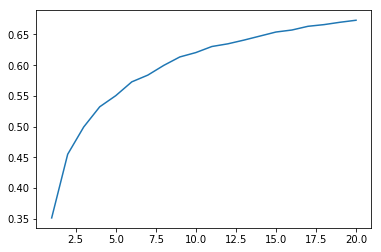

In [17]:
plt.plot(ks, accuracies)

In [18]:
evaluate.mrr(valid_df['ja'].values,
             tr,
             k=20)

0.44319158741978065